The following code loads the environment and makes sure all needed packages are installed. This should be at the start of most Julia scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Teaching/CRA-book/contents/uq`


In [3]:
using Random
using CSVFiles # load CSV data
using DataFrames # data storage and presentation
using Plots # plotting library
default(fmt = :png)
using StatsPlots # statistical plotting
using Distributions # statistical distribution interface
using PDMats # positive-definite matrices
using Turing # probabilistic programming and MCMC
using Optim # optimization library


In [4]:
Random.seed!(1)

TaskLocalRNG()

## Load Data

First, we'll load the data we will use for calibration. The sea-level data was obtained from Australia's [Commonwealth Scientific and Industrial Research Organization (CSIRO)](https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/) and is described in [@churchSealevelRiseLate2011]. This reconstruction of global mean sea levels spans 1880--2019.
has three columns:
1. Time in years (the fractions correspond to months);
2. Global mean sea-level in $mm$ (relative to the 1961-1990 mean);
3. Standard deviation of the observational error in $mm$.

The GMT data was obtained from the [HadCRUT5 website](https://www.metoffice.gov.uk/hadobs/hadcrut5/) [@moriceUpdatedAssessmentSurface2021]. It has a similar structure: a header and comma-delimited. This file also has four columns, along with a header:
1. Time in years;
2. Annual mean temperature anomaly (relative to the 1961-1990 mean);
3. The lower end of the 95% confidence interval;
4. The upper end of the 95% confidence interval.

In [17]:
#| label: tbl-slr-data
#| tbl-align: left
#| tbl-cap: First few rows of the merged GMSL and GMT dataframe.

# load data files
slr_fname = "https://hpc.csiro.au/users/326141/Sea_Level_data/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv"
slr_data = DataFrame(load(slr_fname))
gmt_fname = "https://www.metoffice.gov.uk/hadobs/hadcrut5/data/current/analysis/diagnostics/" * "HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv"
gmt_data = DataFrame(load(gmt_fname))

slr_data[:, :Time] = slr_data[:, :Time] .- 0.5; # remove 0.5 from Times
dat = leftjoin(slr_data, gmt_data, on="Time") # join data frames on time
select!(dat, [1, 2, 4])  # drop columns we don't need
rename!(dat, "Time" => "year", "GMSL (mm)" => "gmsl", "Anomaly (deg C)" => "temp")
first(dat, 6)

Row,year,gmsl,temp
,Float64,Float64,Float64?
1,1880.0,-30.3,-0.315832
2,1881.0,-24.7,-0.232246
3,1882.0,-41.5,-0.29553
4,1883.0,-36.2,-0.346474
5,1884.0,-15.3,-0.49232
6,1885.0,-16.8,-0.471124


Next, let's plot the data series.

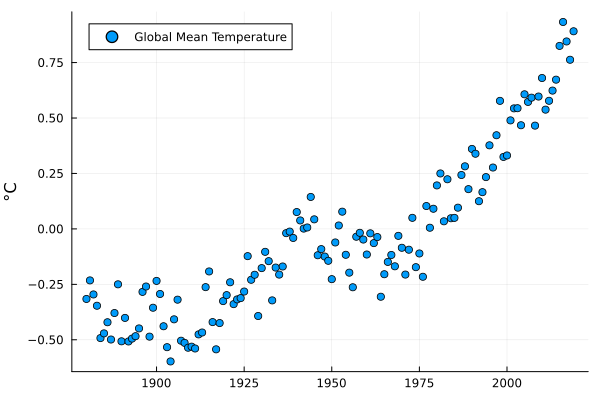

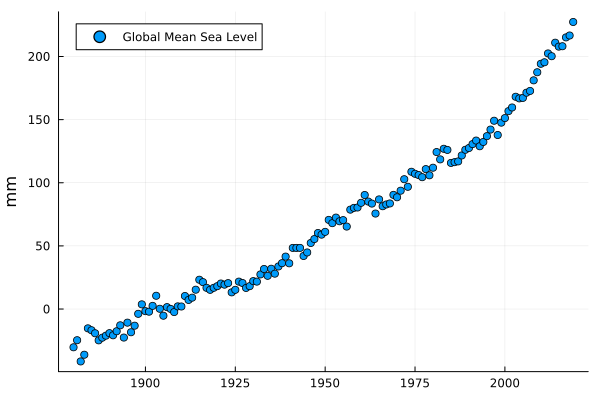

In [6]:
#| label: fig-mcmc-data
#| fig-cap: "Data used for sea-level model calibration."
#| fig-subcap:
#|   - "Global mean temperature anomaly data from [HadCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/) from 1880--2019."
#|   - "Global mean sea-level anomaly reconstruction from [CSIRO](https://research.csiro.au/slrwavescoast/sea-level/measurements-and-data/sea-level-data/) from 1880--2019."
#| fig-alt:
#|   - "Global mean temperature anomaly"
#|   - "Global mean sea-level anomaly"
#| layout-ncol: 2


p1 = @df dat scatter(:year, :temp, ylabel="°C", label="Global Mean Temperature")
display(p1)
p2 = @df dat scatter(:year, :gmsl, ylabel="mm", label="Global Mean Sea Level")
display(p2)

In this notebook, we will use Markov chain Monte Carlo to calibrate the @rahmstorfSemiEmpiricalApproachProjecting2007 semi-empirical sea-level rise model:
$$\frac{dH(t)}{dt} = \alpha (T(t) - T_0),$$
where $H(t)$ is global mean sea-level anomaly (in mm), $T(t)$ is the global mean surface temperature (in $^\circ$ C), $T_0$ is the temperature (in $^\circ$ C) when sea-level rise is in equilibrium, and $\alpha$ is the sea-level rise sensitivity to warming. Discretizing this equation with an annual time step yields
$$H(t+1) = H(t) + \alpha (T(t) - T_0).$$

A key question is what parameter values for this model are consistent with the data. In some cases, this question is interesting to help us understand the dynamics of the system. More generally, if we can express this consistency in the form of probability distributions, we can then use Monte Carlo sampling to propagate this parametric uncertainty through the model to obtain hindcasts and projections.

## Setting up the Model

First, we need a function which represents the @rahmstorfSemiEmpiricalApproachProjecting2007 model. This requires three parameters:
- $\alpha$;
- $T_0$;
- $H_0$ (the initial sea-level anomaly).

We also need to pass in the temperature data. The resulting function is below.

In [7]:
function rahmstorf_model(α, T₀, H₀, temp_data)
    temp_effect = α .* (temp_data .- T₀)
    slr_predict = cumsum(temp_effect) .+ H₀
    return slr_predict
end

rahmstorf_model (generic function with 1 method)

Next, let's specify the statistical model. Denote the residuals as $$R(\mathbf{x}, t)=y_t - F(\mathbf{x}, t),$$ where $y_t$ is the data at time $t$ and $F(\mathbf{x}, t)$ is the model output at time $t$ with parameters $\mathbf{x} = (\alpha, T_0, H_0)$. 

We will assume $R(\mathbf{x}, t)$ is an AR(1) process, *i.e.* 
$$\begin{gather*}
R(\mathbf{x}, t) = \rho z(\mathbf{x}, t-1) + \omega_t, \quad \omega_t \sim \text{Normal}(0, \sigma^2)
\end{gather*}
$$

The unconditional variance of an AR(1) process is $$\text{Var}(z) = \frac{\sigma^2}{1-\rho^2},$$ so the likelihood for $R$ (abusing notation to suppress referencing the parameters) can be written as:
$$
\begin{gather*}
R_1 \sim \text{Normal}(0, \sigma/\sqrt{1-\rho^2}) \\
R_t \sim \text{Normal}(\rho R_{t-1}, \sigma)
\end{gather*}
$$

### Selecting Priors

The last step before we can write our statistical model is to select priors. We will choose relatively uninformative priors for $\alpha$, $T_0$, and $H_0$, using normal distributions. For the scale parameters $\tau$ and $\sigma$, we will choose truncated normal distributions to ensure that they take only positive values. We will also use a uniform prior for $\rho$ over the interval $[-1, 1]$, as $|\rho| < 1$.

In [8]:
@model function slr_posterior(sealevels, temps)
    ## define priors
    α ~ truncated(Normal(0, 2); lower=0)
    T₀ ~ Normal(0, 5)
    H₀ ~ Normal(-100, 50)
    ρ ~ Uniform(-1, 1)
    σ ~ truncated(Normal(0, 5); lower=0)

    ## define likelihood
    # evaluate model
    slr_predict = rahmstorf_model(α, T₀, H₀, temps)
    # compute likelihood
    n = length(temps)
    sealevels[1] ~ Normal(slr_predict[1], σ / sqrt(1-ρ^2)) # initial value
    # loop over subsequent values and add likelihood
    for i = 2:n
        sealevels[i] ~ Normal(ρ * (sealevels[i-1] - slr_predict[i-1]) + slr_predict[i], σ)
    end
end

slr_posterior (generic function with 2 methods)

## Sampling from the Posterior

To sample from the posterior, we use `Turing.sample()`. This requires setting the sampler; we will use the No U-Turn Sampler [@Hoffman2014-gv], which is an adaptive Hamiltonian Monte Carlo sampler. 

We will also use multiple chains, which will let us look at certain convergence diagnostics.

In [9]:
model = slr_posterior(dat[!, 2], dat[!, 3]) # load the data into the model object
n_per_chain = 10000
n_chains = 4
chain =  sample(model, NUTS(), MCMCThreads(), n_per_chain, n_chains; drop_warmup=true) # drop chain warmup iterations

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/F9Hbk/src/sample.jl:296
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.0015625
┌ Info: Found initial step size
└   ϵ = 0.00078125
┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:58


Chains MCMC chain (10000×17×4 Array{Float64, 3}):

Iterations        = 1001:1:11000
Number of chains  = 4
Samples per chain = 10000
Wall duration     = 91.68 seconds
Compute duration  = 89.01 seconds
parameters        = α, T₀, H₀, ρ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse          ess      rhat  ⋯
      Symbol    Float64   Float64    Float64   Float64      Float64   Float64  ⋯

           α     2.0597    0.1876     0.0009    0.0017   12492.4117    1.0001  ⋯
          T₀    -0.9073    0.0793     0.0004    0.0007   11165.8600    1.0001  ⋯
          H₀   -28.3468    2.9007     0.0145    0.0237   14146.5801    1.0001  ⋯
           ρ     0.5959    0.0757     0.0004    0.0006   16793.6076    1.0001  ⋯
           σ     5.0955    0.3108     0.0016    0.002

## Diagnosing Convergence

The first step in diagnosing convergence is to look at the traceplots and marginal distributions of the chains. If multiple chains, which were initialized at various values, have the same distribution, that is evidence of convergence.

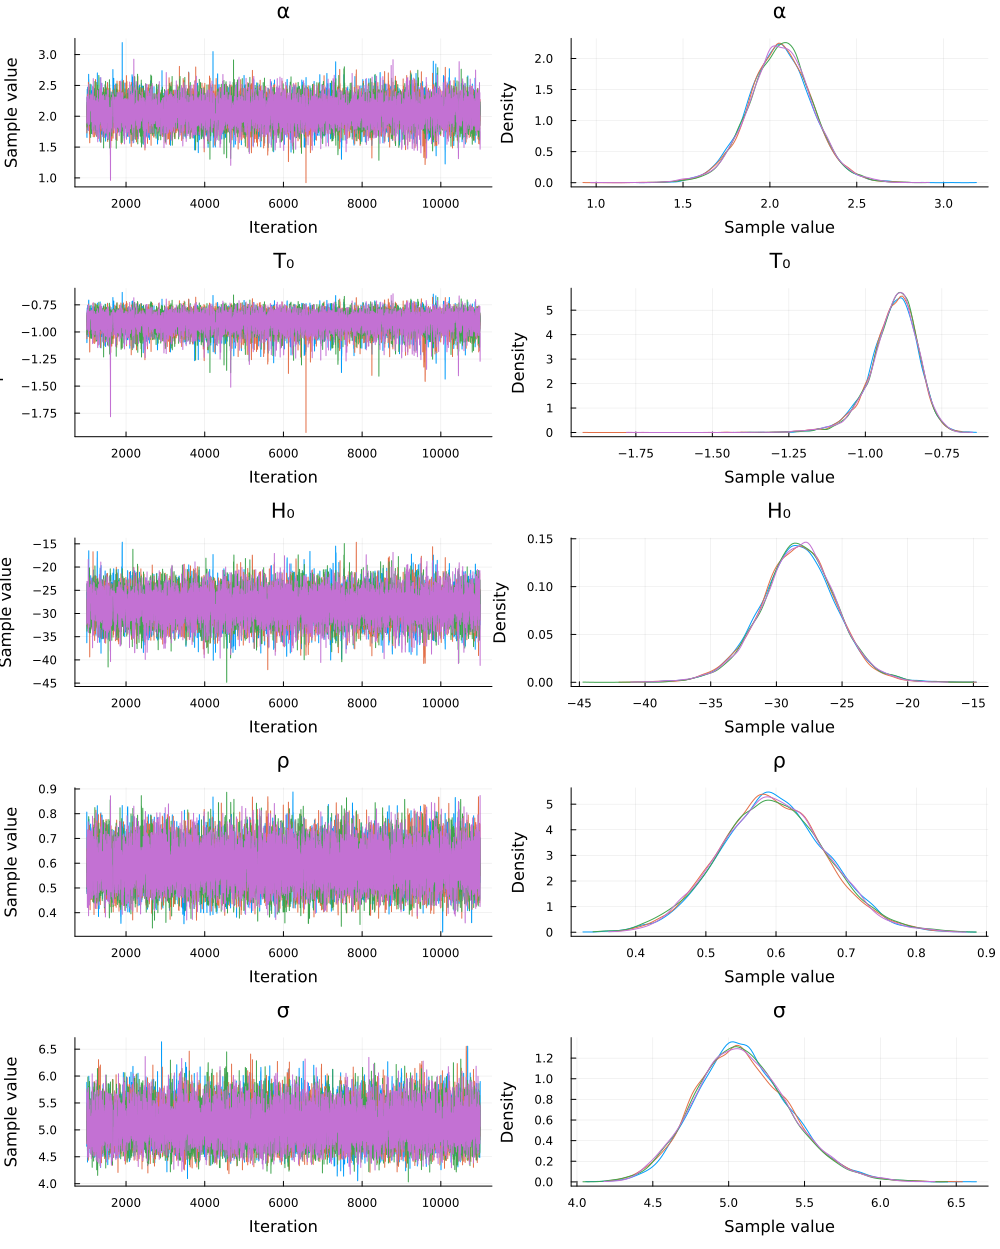

In [10]:
#| label: fig-mcmc-traceplot
#| fig-cap: "Traceplots and marginal posterior distributions from the MCMC sampler. Each individual chain's samples are shown in a different color."
#| fig-alt: "MCMC sampler output"

plot(chain)

We can also look at the Gelman-Rubin statistic $\hat{R}$, which is based on comparing the variation between chains to the variation within a single chain. The closer $\hat{R}$ is to 1, the more evidence for convergence, as this suggests the between-chain variation is close to zero.

In [16]:
#| label: gelmandiag

gelmandiag(chain)

Gelman, Rubin, and Brooks diagnostic
  parameters      psrf    psrfci 
      Symbol   Float64   Float64 

           α    1.0002    1.0006
          T₀    1.0004    1.0008
          H₀    1.0002    1.0005
           ρ    1.0002    1.0004
           σ    1.0002    1.0008


## Visualizing Relationships Between Parameters

The previous plot let us look at the *marginal* posterior distributions, that is, the distribution for that parameter only. However, we are more commonly interested in the *joint* distribution, which accounts for correlations between the parameters. We can see these correlations with a cornerplot.

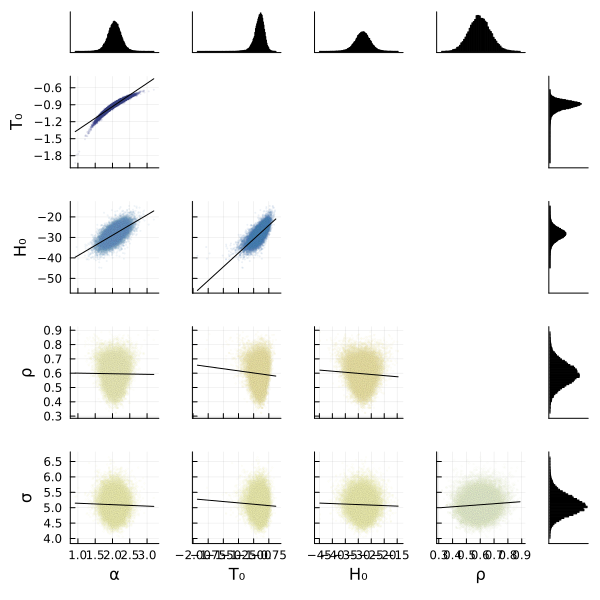

In [12]:
#| label: fig-mcmc-corner
#| fig-cap: Corner plot between the sampled parameters. The plots along the lower triangle show scatterplots between the corresponding two variables. In the margin are marginal density plots. If the scatterplots are colored blue, the two variables are positively correlated, and red shows a negative correlation.

corner(chain)

We can see, for example, that $\alpha$, $T_0$, and $H_0$ are highly positively correlated with each other. This makes sense, as a larger value of $\alpha$ means that sea-level is more sensitive to temperature increases over $T_0$. As a result, if $T_0$ is low and $\alpha$ is high, the resulting modeled sea level anomaly will be larger than the observations. Conversely, if $T_0$ is high and $\alpha$ is low, the model will under-predict the level of sea-level rise. Similar logic also explains why $H_0$ should be positively correlated with $\alpha$ and $T_0$.

## References